In [1]:
DEBUG=False

In [2]:
%run ./nb_core/root_dirs.ipynb
setup_syspath_disentangle(DEBUG)
%run ./nb_core/disentangle_imports.ipynb

DATA_ROOT:	 /group/jug/ashesh/data/
CODE_ROOT:	 /home/ashesh.ashesh/


/home/ashesh.ashesh/mambaforge/envs/usplit/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
ckpt_dir = "/home/ashesh.ashesh/training/disentangle/2310/D3-M23-S7-L0/38"

In [4]:
dtype = int(ckpt_dir.split('/')[-2].split('-')[0][1:])
if DEBUG:
    if dtype == DataType.CustomSinosoid:
        data_dir = f'{DATA_ROOT}/sinosoid/'
    elif dtype == DataType.OptiMEM100_014:
        data_dir = f'{DATA_ROOT}/microscopy/'
else:
    if dtype in [DataType.CustomSinosoid, DataType.CustomSinosoidThreeCurve]:
        data_dir = f'{DATA_ROOT}/sinosoid_without_test/sinosoid/'
    elif dtype == DataType.OptiMEM100_014:
        data_dir = f'{DATA_ROOT}/microscopy/'
    elif dtype == DataType.Prevedel_EMBL:
        data_dir = f'{DATA_ROOT}/Prevedel_EMBL/PKG_3P_dualcolor_stacks/NoAverage_NoRegistration/'
    elif dtype == DataType.AllenCellMito:
        data_dir = f'{DATA_ROOT}/allencell/2017_03_08_Struct_First_Pass_Seg/AICS-11/'
    elif dtype == DataType.SeparateTiffData:
        data_dir = f'{DATA_ROOT}/ventura_gigascience'
    elif dtype == DataType.SemiSupBloodVesselsEMBL:
        data_dir = f'{DATA_ROOT}/EMBL_halfsupervised/Demixing_3P'
    elif dtype == DataType.Pavia2VanillaSplitting:
        data_dir = f'{DATA_ROOT}/pavia2'
    elif dtype == DataType.ExpansionMicroscopyMitoTub:
        data_dir = f'{DATA_ROOT}/expansion_microscopy_Nick/'
    elif dtype == DataType.ShroffMitoEr:
        data_dir = f'{DATA_ROOT}/shrofflab/'
    elif dtype == DataType.HTIba1Ki67:
        data_dir = f'{DATA_ROOT}/Stefania/20230327_Ki67_and_Iba1_trainingdata/'
        
#     2720*2720: microscopy dataset.

image_size_for_grid_centers = None
mmse_count = 1
custom_image_size = None



batch_size = 32
num_workers = 4
COMPUTE_LOSS = False
use_deterministic_grid = None
threshold = None # 0.02
compute_kl_loss = False
evaluate_train = False# inspect training performance
eval_datasplit_type = DataSplitType.Test
val_repeat_factor = None
psnr_type = 'range_invariant' #'simple', 'range_invariant'

In [5]:
%run ./nb_core/config_loader.ipynb

data:
  background_quantile: 0.0
  channel_1: 2
  channel_2: 3
  clip_background_noise_to_zero: false
  clip_percentile: 0.995
  data_type: 3
  deterministic_grid: true
  image_size: 512
  innerpad_amount: 128
  input_is_sum: false
  multiscale_lowres_count: null
  normalized_input: true
  padding_mode: reflect
  padding_value: null
  randomized_channels: false
  sampler_type: 7
  skip_normalization_using_mean: false
  target_separate_normalization: false
  train_aug_rotate: false
  use_one_mu_std: true
  val_grid_size: 256
datadir: /group/jug/ashesh/data/microscopy/
exptname: 2310/D3-M23-S7-L0/38
git:
  branch: autoregressive_v6
  changedFiles: []
  latest_commit: 985deeb9c1a1f10c0a9a0ce1dee9641fd016e199
  untracked_files: []
hostname: gnode07
loss:
  free_bits: 0.0
  kl_annealing: false
  kl_annealtime: 10
  kl_min: 1.0e-07
  kl_start: -1
  kl_weight: 0.1
  loss_type: 0
model:
  analytical_kl: false
  decoder:
    batchnorm: true
    blocks_per_layer: 1
    conv2d_bias: true
    drop

In [6]:
from denoisplit.core.sampler_type import SamplerType
from denoisplit.core.loss_type import LossType
from denoisplit.data_loader.ht_iba1_ki67_rawdata_loader import SubDsetType
# from denoisplit.core.lowres_merge_type import LowresMergeType


with config.unlocked():
    config.model.skip_nboundary_pixels_from_loss = None
    if config.model.model_type == ModelType.UNet and 'n_levels' not in config.model:
        config.model.n_levels = 4
    if config.data.sampler_type == SamplerType.NeighborSampler:
        config.data.sampler_type = SamplerType.DefaultSampler
        config.loss.loss_type = LossType.Elbo
        config.data.grid_size = config.data.image_size
    if 'ch1_fpath_list' in config.data:
        config.data.ch1_fpath_list = config.data.ch1_fpath_list[:1]
        config.data.mix_fpath_list = config.data.mix_fpath_list[:1]
    if config.data.data_type == DataType.Pavia2VanillaSplitting:
        if 'channel_2_downscale_factor' not in config.data:
            config.data.channel_2_downscale_factor = 1
    if config.model.model_type == ModelType.UNet and 'init_channel_count' not in config.model:
        config.model.init_channel_count = 64
    
    if 'skip_receptive_field_loss_tokens' not in config.loss:
        config.loss.skip_receptive_field_loss_tokens = []
    
    if dtype == DataType.HTIba1Ki67:
        config.data.subdset_type = SubDsetType.Iba1Ki64
        config.data.empty_patch_replacement_enabled = False
    
    if 'lowres_merge_type' not in config.model.encoder:
        config.model.encoder.lowres_merge_type = 0
    
    if config.model.model_type == ModelType.AutoRegresiveRALadderVAE:
        patch_size = custom_image_size if custom_image_size is not None else config.data.image_size
        grid_size = image_size_for_grid_centers if image_size_for_grid_centers is not None else patch_size - 2*config.data.innerpad_amount
        assert grid_size % 2 == 0
        
        config.data.innerpad_amount = (patch_size - grid_size) // 2
        image_size_for_grid_centers = grid_size
        # config.data.grid_size = image_size_for_grid_centers
        config.data.val_grid_size = image_size_for_grid_centers

In [7]:
%run ./nb_core/disentangle_setup.ipynb


<class 'disentangle.data_loader.multi_channel_determ_tiff_dloader.MultiChDeterministicTiffDloader'>
Loading /group/jug/ashesh/data//microscopy/OptiMEM100x014.tif with Channels 2,3,datasplit mode:Train
[MultiChDeterministicTiffDloader] Sz:512 Train:1 N:49 NumPatchPerN:25 NormInp:True SingleNorm:True Rot:False RandCrop:False Q:0.995 SummedInput:False ReplaceWithRandSample:False BckQ:0.0
Loading /group/jug/ashesh/data//microscopy/OptiMEM100x014.tif with Channels 2,3,datasplit mode:Test
[MultiChDeterministicTiffDloader] Sz:512 Train:0 N:6 NumPatchPerN:100 NormInp:True SingleNorm:True Rot:False RandCrop:False Q:0.995 SummedInput:False ReplaceWithRandSample:False BckQ:0.0

config.pkl
[3, 3] [1, 1]
[3, 3] [1, 1]
[BottomUpLayer] McEnabled:0 
[3, 3] [1, 1]
[3, 3] [1, 1]
[3, 3] [1, 1]
[TopDownLayer] normalize_latent_factor:1.0
[3, 3] [1, 1]
[BottomUpLayer] McEnabled:0 
[3, 3] [1, 1]
[3, 3] [1, 1]
[3, 3] [1, 1]
[TopDownLayer] normalize_latent_factor:1.0
[3, 3] [1, 1]
[BottomUpLayer] McEnabled:0 

AssertionError: 

AssertionError: 

In [8]:
def get_kth_ckpt(epoch_num):
    for fnane in os.listdir(ckpt_dir):
        if fnane.startswith(f'epoch={epoch_num}-'):
            return os.path.join(ckpt_dir, fnane)
        
    raise ValueError(f'No ckpt found for epoch {epoch_num}')

In [9]:
def get_kth_ckpt_model(epoch_num):
    ckpt_fpath = get_kth_ckpt(epoch_num)
    checkpoint = torch.load(ckpt_fpath)
    model = create_model(config, mean_fr_model,std_fr_model)
    _ = model.load_state_dict(checkpoint['state_dict'])
    model.eval()
    # _= model.cuda()
    # model.set_params_to_same_device_as(torch.Tensor(1).cuda())

    print('Loading from epoch', checkpoint['epoch'])
    return model

torch.Size([64, 64, 3, 3])

In [70]:
weights_begin = []
weights_end = []
skip_epoch= 1
# for epoch_num in range(0,100, skip_epoch):
for epoch_num in range(75,100, skip_epoch):

    model = get_kth_ckpt_model(epoch_num)
    weights_begin.append(model.bottom_up_layers[-1].net_downsized[0].pre_conv.weight.data.cpu().numpy())
    # weights_end.append(model.top_down_layers[0].deterministic_block[0].pre_conv.weight.data.cpu().numpy())
    weights_end.append(model.final_top_down[0].res.block[2].weight.data.cpu().numpy())


[3, 3] [1, 1]
[3, 3] [1, 1]
[BottomUpLayer] McEnabled:0 
[3, 3] [1, 1]
[3, 3] [1, 1]
[3, 3] [1, 1]
[TopDownLayer] normalize_latent_factor:1.0
[3, 3] [1, 1]
[BottomUpLayer] McEnabled:0 
[3, 3] [1, 1]
[3, 3] [1, 1]
[3, 3] [1, 1]
[TopDownLayer] normalize_latent_factor:1.0
[3, 3] [1, 1]
[BottomUpLayer] McEnabled:0 
[3, 3] [1, 1]
[3, 3] [1, 1]
[3, 3] [1, 1]
[TopDownLayer] normalize_latent_factor:1.0
[3, 3] [1, 1]
[BottomUpLayer] McEnabled:0 
[3, 3] [1, 1]
[TopDownLayer] normalize_latent_factor:1.0
[3, 3] [1, 1]
[GaussianLikelihood] PredLVar:pixelwise LowBLVar:-5
[AutoRegRALadderVAE] Enc [ResKSize3 SkipPadding:False]  Dec [ResKSize3 SkipPadding:False] Stoc:True
[SolutionRAManager] Train P512 Sk128 D0.2
[SolutionRAManager] Val P512 Sk128 D0.0
[SolutionRAManager] Val P512 Sk128 D0.0
[3, 3] [1, 1]
[3, 3] [1, 1]
[3, 3] [1, 1]
[3, 3] [1, 1]
[3, 3] [1, 1]
[3, 3] [1, 1]
[BottomUpLayer] McEnabled:0 
[3, 3] [1, 1]
[BottomUpLayer] McEnabled:0 
[3, 3] [1, 1]
[BottomUpLayer] McEnabled:0 
[3, 3] [1, 1]
[

<Axes: >

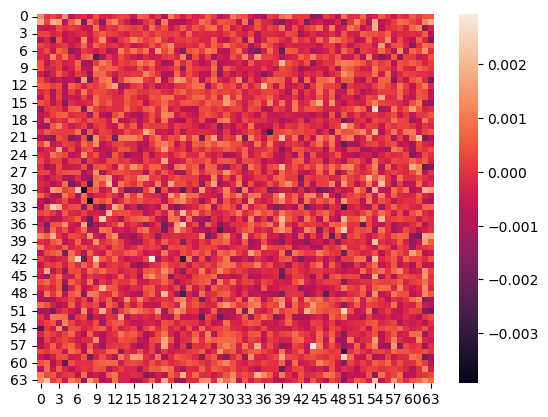

In [71]:
import seaborn as sns
ki = 0
kj = 1
sns.heatmap(weights_begin[2][...,ki,kj] -weights_begin[0][...,ki,kj])

## Looking at how the weights evolve during training

In [72]:
%matplotlib inline
import numpy as np
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
ymax_begin = -np.inf
ymin_begin = np.inf
ymax_end = -np.inf
ymin_end = np.inf

def get_diff(w1, w2):
    return np.mean(np.abs(w1-w2), axis=(0,2,3)).reshape(-1,)

for i in range(1,len(weights_begin)):
    ymax_begin = max(ymax_begin, np.max(get_diff(weights_begin[i],weights_begin[i-1])))
    ymin_begin = min(ymin_begin, np.min(get_diff(weights_begin[i],weights_begin[i-1])))
    ymax_end = max(ymax_end, np.max(get_diff(weights_end[i], weights_end[i-1])))
    ymin_end = min(ymin_end, np.min(get_diff(weights_end[i], weights_end[i-1])))

ymax = max(ymax_begin, ymax_end)
ymin = min(ymin_begin, ymin_end)

def plot_func(i):
    i = int(i)
    _,ax = plt.subplots(figsize=(6,3),ncols=2)
    # ax[0].plot((weights_begin[i] - weights_begin[i-1]).reshape(-1))
    # ax[1].plot((weights_end[i] - weights_end[i-1]).reshape(-1))
    ax[0].plot(get_diff(weights_begin[i], weights_begin[i-1]))
    ax[1].plot(get_diff(weights_end[i], weights_end[i-1]))
    ax[0].set_ylim(ymin, ymax)
    ax[1].set_ylim(ymin, ymax)

interact(plot_func, i = widgets.FloatSlider(value=1,
                                               min=1,
                                               max=len(weights_begin)-1,
                                               step=1))

interactive(children=(FloatSlider(value=1.0, description='i', max=24.0, min=1.0, step=1.0), Output()), _dom_cl…

<function __main__.plot_func(i)>

## Average weight evolution

In [73]:
def get_one_output_channel(w):
    return np.mean(np.abs(w), axis=(0,2,3))

ymax = -np.inf
ymin = np.inf
for i in range(1,len(weights_begin)):
    ymax = max(ymax, get_one_output_channel(weights_begin[i]).max())
    ymax = max(ymax, get_one_output_channel(weights_end[i]).max())
    ymin = min(ymin, get_one_output_channel(weights_begin[i]).min())
    ymin = min(ymin, get_one_output_channel(weights_end[i]).min())

def plot_func2(i):
    i = int(i)
    _,ax = plt.subplots(figsize=(6,3),ncols=2)
    ax[0].plot(get_one_output_channel(weights_begin[i]))
    ax[1].plot(get_one_output_channel(weights_end[i]))
    ax[0].set_ylim(ymin, ymax)
    ax[1].set_ylim(ymin, ymax)

interact(plot_func2, i = widgets.FloatSlider(value=1,
                                               min=1,
                                               max=len(weights_begin)-1,
                                               step=1))

interactive(children=(FloatSlider(value=1.0, description='i', max=24.0, min=1.0, step=1.0), Output()), _dom_cl…

<function __main__.plot_func2(i)>

In [74]:
val_dset